In [ ]:
import numpy as np
import pandas as pd
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import torchvision
from torch.autograd import Variable
from PIL import Image
import PIL.ImageOps
import os

import config
from utils import imshow, show_plot
from contrastive import ContrastiveLoss

In [ ]:
#load the dataset
training_dir="/content/drive/My Drive/Projetos/SiameseNetwork/data/train"
training_csv="/content/drive/My Drive/Projetos/SiameseNetwork/data/train_data.csv"
testing_csv="/content/drive/My Drive/Projetos/SiameseNetwork/data/test_data.csv"
testing_dir="/content/drive/My Drive/Projetos/SiameseNetwork/data/test"

In [ ]:
#preprocessing
class SiameseDataset():
    
    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.train_df=pd.read_csv(training_csv)
        self.train_df.columns =["image1","image2","label"]
        self.train_dir = training_dir    
        self.transform = transform

    def __getitem__(self,index):
        
        # getting the image path
        image1_path=os.path.join(self.train_dir,self.train_df.iat[index,0])
        image2_path=os.path.join(self.train_dir,self.train_df.iat[index,1])
        
        
        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , th.from_numpy(np.array([int(self.train_df.iat[index,2])],dtype=np.float32))
    
    def __len__(self):
        return len(self.train_df)

In [ ]:
# Load the the dataset
siamese_dataset = SiameseDataset(training_csv,training_dir,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

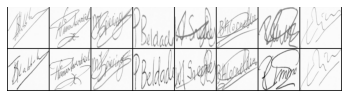

[[1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]]


In [ ]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = th.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [ ]:
#siamese network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

        )
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2))
        
  
  
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=batch_size)   

net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = th.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)

Epoch 1
 Current loss 1.2470513582229614

Epoch 2
 Current loss 1.4196090698242188

Epoch 3
 Current loss 0.9840202331542969

Epoch 4
 Current loss 0.9915735125541687

Epoch 5
 Current loss 1.3675466775894165

Epoch 6
 Current loss 1.389392375946045

Epoch 7
 Current loss 1.1003986597061157

Epoch 8
 Current loss 1.3771209716796875

Epoch 9
 Current loss 0.8158280849456787

Epoch 10
 Current loss 1.2433712482452393

Epoch 11
 Current loss 1.1476798057556152

Epoch 12
 Current loss 0.9509873986244202

Epoch 13
 Current loss 1.0380736589431763

Epoch 14
 Current loss 1.0037964582443237

Epoch 15
 Current loss 1.0552754402160645

Epoch 16
 Current loss 1.1190322637557983

Epoch 17
 Current loss 1.1633440256118774

Epoch 18
 Current loss 0.8474604487419128

Epoch 19
 Current loss 1.287433385848999



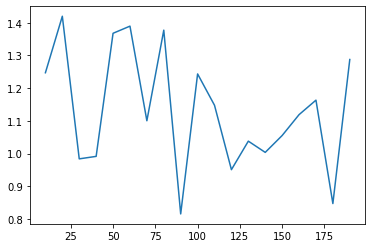

Model Saved Successfully


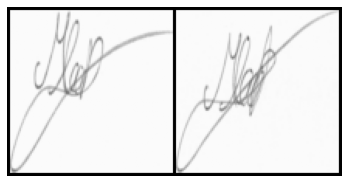

Predicted Eucledian Distance:- 0.31665703654289246
Actual Label:- Original Pair Of Signature


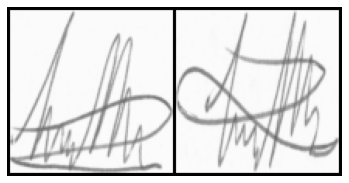

Predicted Eucledian Distance:- 0.42964786291122437
Actual Label:- Original Pair Of Signature


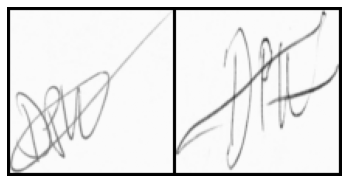

Predicted Eucledian Distance:- 0.4557238519191742
Actual Label:- Forged Pair Of Signature


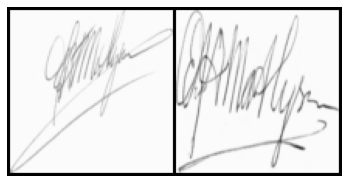

Predicted Eucledian Distance:- 0.09266361594200134
Actual Label:- Forged Pair Of Signature


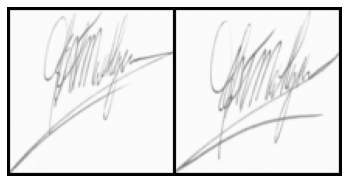

Predicted Eucledian Distance:- 0.2762422263622284
Actual Label:- Original Pair Of Signature


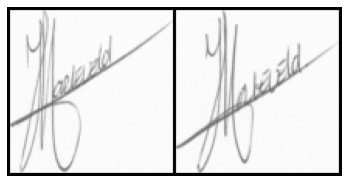

Predicted Eucledian Distance:- 0.8244780898094177
Actual Label:- Original Pair Of Signature


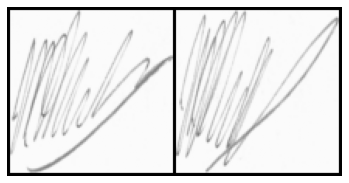

Predicted Eucledian Distance:- 1.1357501745224
Actual Label:- Original Pair Of Signature


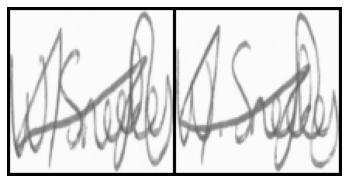

Predicted Eucledian Distance:- 0.6889777779579163
Actual Label:- Original Pair Of Signature


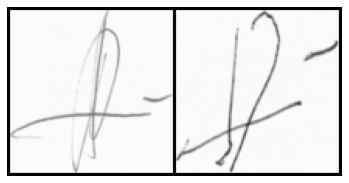

Predicted Eucledian Distance:- 0.2182880938053131
Actual Label:- Forged Pair Of Signature


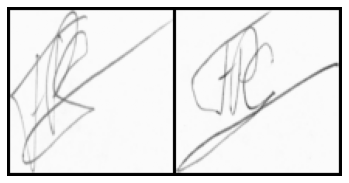

Predicted Eucledian Distance:- 1.2028354406356812
Actual Label:- Forged Pair Of Signature


In [ ]:
#train model
def train():
    loss=[] 
    counter=[]
    iteration_number = 0


    for epoch in range(1,epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            
        print("Epoch {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
        iteration_number += 10
        counter.append(iteration_number)
        loss.append(loss_contrastive.item())
    show_plot(counter, loss)   
    return net

#set device to cuda
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
model = train()
th.save(model.state_dict(), "model.pt")
print("Model Saved Successfully") 

#Load test dataset
test_dataset = SiameseDataset(training_csv=testing_csv,training_dir=testing_dir,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)

count=0
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  concat = th.cat((x0,x1),0)
  output1,output2 = model(x0.to(device),x1.to(device))

  eucledian_distance = F.pairwise_distance(output1, output2)
    
  if label==th.FloatTensor([[0]]):
    label="Original Pair Of Signature"
  else:
    label="Forged Pair Of Signature"
    
  imshow(torchvision.utils.make_grid(concat))
  print("Predicted Eucledian Distance:-",eucledian_distance.item())
  print("Actual Label:-",label)
  count=count+1
  if count ==10:
     break
